## Make DataBase From Kitti Object Dection

In [34]:
import numpy as np
import glob
import random
import os

import open3d as o3d
from pyntcloud import PyntCloud

from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d.axes3d import Axes3D
from progressbar import *  

In [26]:
folder_ground_truth = 'D:/xr/study/point cloud/Dataset/training/label_2'
folder_point_cloud = 'D:/xr/study/point cloud/Dataset/training/velodyne'
files_ground_truth = glob.glob(folder_ground_truth + '/*.txt')
print("There are ", len(files_ground_truth), " files")

There are  7481  files


prepare the axis visualization object

In [94]:
axis_set = o3d.geometry.LineSet()
axis_length = 2.0
points_vis_axis = [ [0,0,0],[axis_length,0,0],[0,axis_length,0], [0,0,axis_length]]
lines_vis_axis = [[0,1],[0,2],[0,3]]
axis_set.lines = o3d.utility.Vector2iVector(lines_vis_axis)
axis_set.points  = o3d.utility.Vector3dVector(points_vis_axis)
colors = [[1,0,0] ,[0,1,0], [0,0,1]]
axis_set.colors = o3d.utility.Vector3dVector(colors)

## 1. Cut points from a 3D bounding box

* one way : get the bounding box, and cut from the original point cloud (compute faster, code harder)
* another way : transfrom and rotate the point cloud, then simply threshold by x, y and z (computer slower, code easier)


### 1.1 Get the 3D bounding box

In [39]:
def load_velo_scan(file):
    """Load and parse a velodyne binary file."""
    scan = np.fromfile(file, dtype=np.float32)
    return scan.reshape((-1, 4))

In [202]:
def get_3d_box(ry, t1, t2, t3, w, h, l):
    # print(ry, t1, t2, t3, w, h, l)
    ry_rod = ry
    points_vis_axis = np.array([[l/2, w/2, 0],[l/2,-w/2, 0],[-l/2, w/2, 0], [-l/2, -w/2, 0], [l/2, w/2, h],[l/2,-w/2, h],[-l/2, w/2, h], [-l/2, -w/2, h]])
    rotation_matrix = np.array([[np.cos(ry_rod), np.sin(ry_rod), 0], [-np.sin(ry_rod), np.cos(ry_rod), 0], [0,0,1]])
    rotated_cloud = np.dot(rotation_matrix, (points_vis_axis.transpose())).transpose()
    points_vis_axis = rotated_cloud + np.array([t1, t3, -t2])
    
    # need to rotate another 90 degrees -> coordinate change
    ry_rod = np.pi/2
    rotation_matrix = np.array([[np.cos(ry_rod), np.sin(ry_rod), 0], [-np.sin(ry_rod), np.cos(ry_rod), 0], [0,0,1]])
    points_vis_axis = np.dot(rotation_matrix, (points_vis_axis.transpose())).transpose()
    
    lines_vis_axis = [[0, 1], [0, 2], [1, 3], [2, 3], [4, 5], [4, 6], [5, 7], [6, 7], [0,4],[1,5],[2,6],[3,7]]
    
    colors_box = [[0, 0, 1] for i in range(len(lines_vis_axis))]
    box_set = o3d.geometry.LineSet()
    box_set.lines = o3d.utility.Vector2iVector(lines_vis_axis)
    box_set.points  = o3d.utility.Vector3dVector(points_vis_axis.tolist())
    box_set.colors = o3d.utility.Vector3dVector(colors_box)
    
    return box_set


#### here is the output 3d bounding box example (using get_3d_box(ry, t1, t2, t3, w, h, l) later part of this notebook)
![title](images/bbx.PNG)

### 1.2 Cut the points

In [113]:
# test show
point_cloud_test = load_velo_scan("D:/xr/study/point cloud/Dataset/training/velodyne/000010.bin")
print(" point cloud shape is : ", point_cloud_test.shape)
point_cloud_o3d = o3d.geometry.PointCloud()
point_cloud_o3d.points = o3d.utility.Vector3dVector(point_cloud_test[:,0:3])
o3d.visualization.draw_geometries([point_cloud_o3d, axis_set])

 point cloud shape is :  (115875, 4)


In [244]:
def rotate_and_threshold_pointcloud(pointcloud, ry, t1, t2, t3, w, h, l):
    pointcloud_tmp = pointcloud[:, 0:3]
    
    # need to rotate another 90 degrees -> coordinate change
    ry_rod = - np.pi/2
    rotation_matrix = np.array([[np.cos(ry_rod), np.sin(ry_rod), 0], [-np.sin(ry_rod), np.cos(ry_rod), 0], [0,0,1]])
    pointcloud_tmp = np.dot(rotation_matrix, (pointcloud_tmp.transpose())).transpose()
    
    ry_rod = -ry
    rotation_matrix = np.array([[np.cos(ry_rod), np.sin(ry_rod), 0], [-np.sin(ry_rod), np.cos(ry_rod), 0], [0,0,1]])
    # translate
    translated_cloud = pointcloud_tmp - np.array([t1,t3,-t2])
    # rotate
    rotated_cloud = np.dot(rotation_matrix, (translated_cloud.transpose())).transpose()
    # filter
    x_flag = np.logical_and([rotated_cloud[:,0] <= l/2], [rotated_cloud[:,0] >= -l/2])
    y_flag = np.logical_and([rotated_cloud[:,1] <= w/2], [rotated_cloud[:,1] >= -w/2])
    
    # cut more points from the round
    z_flag = np.logical_and([rotated_cloud[:,2] <= h], [rotated_cloud[:,2] >= 0.1])
    final_flag = np.logical_and(x_flag, y_flag)
    final_flag = np.logical_and(final_flag, z_flag)
    output_points = pointcloud[final_flag[0]]
    return output_points

In [243]:
point_cloud_test = load_velo_scan("D:/xr/study/point cloud/Dataset/training/velodyne/000010.bin")
output = rotate_and_threshold_pointcloud(point_cloud_test,  -1.42,  4.43, 1.65, 5.20, 1.65, 1.57, 3.35)

point_cloud_o3d = o3d.geometry.PointCloud()
point_cloud_o3d.points = o3d.utility.Vector3dVector(output[:,0:3])
o3d.visualization.draw_geometries([point_cloud_o3d, axis_set])

we take the threshold of height a little bit higher, to better avoid groud points.
![title](images/cut_pt.PNG)

## 2. Load groung truth and get points

### 2.1 show all the bounding box

In [237]:
def decode_ground_truth_line(gt_line):
    # str, &trash, &trash, &d.box.alpha, &d.box.x1, &d.box.y1, &d.box.x2, &d.box.y2, &d.h, &d.w, &d.l, &d.t1, &d.t2, &d.t3, &d.ry
    splits_gt = gt_line.split(' ')
#     print('label is : ', splits_gt[0])
#     print('box height : ', splits_gt[8])
#     print('box width : ', splits_gt[9])
#     print('box length : ', splits_gt[10])
#     print('box coordinat : ',splits_gt[11], splits_gt[12], splits_gt[13] )
#     print('box angle : ', splits_gt[14])
    # return h, w, l, t1, t2, t3, ry
    return float(splits_gt[8]), float(splits_gt[9]), float(splits_gt[10]), float(splits_gt[11]), float(splits_gt[12]), float(splits_gt[13]), float(splits_gt[14]),  

def load_ground_true(file_gt):
    file_name = file_gt[-10:-4]
    file_velodyne = folder_point_cloud + '/' + file_name + '.bin'
    #print(file_velodyne)
    
    file = open(file_gt, 'r')
    box_sets = []
    while True:
        text_line = file.readline()
        if text_line:
            h, w, l, t1, t2, t3, ry = decode_ground_truth_line(text_line)
            if(t1 < -100):
                continue
            box_set = get_3d_box(ry, t1, t2, t3, w, h, l)
            #print(type(text_line), text_line)
            box_sets.append(box_set)
        else:
            break
    file.close()
    return box_sets, file_velodyne

In [536]:
# test
idx = 458
print(files_ground_truth[idx])
show_sets, file_velodyne = load_ground_true(files_ground_truth[idx])

# test show
point_cloud_test = load_velo_scan(file_velodyne)
print(" point cloud shape is : ", point_cloud_test.shape)
point_cloud_o3d = o3d.geometry.PointCloud()
point_cloud_o3d.points = o3d.utility.Vector3dVector(point_cloud_test[:,0:3])
show_sets.append(point_cloud_o3d)
show_sets.append(axis_set)
o3d.visualization.draw_geometries(show_sets)

D:/xr/study/point cloud/Dataset/training/label_2\000150.txt
 point cloud shape is :  (122445, 4)


### 2.2 Cut the wanted pointclouds

In [246]:
output_folder = 'D:/xr/study/point cloud/Dataset/TransformedClassificationSet'

In [286]:
def save_points_to_ply(cloud, file_name):
    file_out = open(file_name, "w")

    file_out.write('ply\nformat ascii 1.0\ncomment Created by LIUYE\n')
    str_size = 'element vertex ' + str(cloud.shape[0]) + '\n'
    file_out.write(str_size)
    file_out.write('property float x\nproperty float y\nproperty float z\nproperty float intensity\nend_header\n')
    
    for i in range(cloud.shape[0]):
        str_pt = str(cloud[i,0]) + ' ' + str(cloud[i,1]) + ' ' + str(cloud[i,2]) + ' ' + str(cloud[i,3]) + '\n'
        file_out.write(str_pt)
    
    file_out.close()

In [388]:
count_classes = np.zeros(3).astype(int)

def decode_ground_truth_line_and_choose(gt_line):
    # fail label is t1 = -1000
    # str, &trash, &trash, &d.box.alpha, &d.box.x1, &d.box.y1, &d.box.x2, &d.box.y2, &d.h, &d.w, &d.l, &d.t1, &d.t2, &d.t3, &d.ry
    splits_gt = gt_line.split(' ')
    label = -1
    if(splits_gt[0] == 'Car'):
        label = 0
    elif(splits_gt[0] == 'Cyclist'):
        label = 1
    elif(splits_gt[0] == 'Pedestrian'):
        label = 2
    return label, float(splits_gt[8]), float(splits_gt[9]), float(splits_gt[10]), float(splits_gt[11]), float(splits_gt[12]), float(splits_gt[13]), float(splits_gt[14]),  

def cut_ground_true_clouds(file_gt, save_path, if_save = True):
    file_name = file_gt[-10:-4]
    file_velodyne = folder_point_cloud + '/' + file_name + '.bin'
    #print(file_velodyne)
    point_cloud_test = load_velo_scan(file_velodyne)
    
    file = open(file_gt, 'r')
    label_clouds = []
    labels = []
    while True:
        text_line = file.readline()
        if text_line:
            label, h, w, l, t1, t2, t3, ry = decode_ground_truth_line_and_choose(text_line)
            if(t1 < -100):
                continue
            if(label == -1):
                continue
            #rotate_and_threshold_pointcloud(pointcloud, ry, t1, t2, t3, w, h, l):
            label_pts = rotate_and_threshold_pointcloud(point_cloud_test, ry, t1, t2, t3, w, h, l)
            #print(label, label_pts.shape)
            
            file_name = save_path + '/' + str(label) + '/' + str(count_classes[label]) + '.ply'
            count_classes[label] += 1
            if(if_save):
                save_points_to_ply(label_pts, file_name)
                
            label_clouds.append(label_pts)
            labels.append(label)
        else:
            break
    file.close()
    return label_clouds, labels

D:/xr/study/point cloud/Dataset/training/label_2\000010.txt


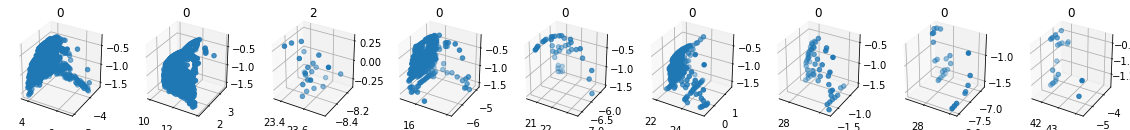

In [389]:
# test
count_classes = np.zeros(3).astype(int)
idx = 10
print(files_ground_truth[idx])
label_clouds, labels = cut_ground_true_clouds(files_ground_truth[idx], output_folder, False)

# show points
num_pts = len(label_clouds)
fig = plt.figure(figsize=(20,2))
for i in range(num_pts):
    ax1 = fig.add_subplot(1, num_pts, i+1, projection='3d')
    ax1.scatter(label_clouds[i][:,0], label_clouds[i][:,1], label_clouds[i][:,2])
    ax1.set_title(str(labels[i]))

### 2.2 Make Data Set

#### Data set making:
Which data to use for final test. 
* We donnot have the ground truth for the testing set of "KITTI OBJECT DETECTION" set. We can only evaluate the result from trainning set. So we need to seperate the trainning set to train and test set. 
* seperate and find clouds in trainning set. 
* save the files of testing set to an txt file.

In [387]:
num_all = len(files_ground_truth)
num_trainning = (int)(num_all * 0.8)
num_testing = num_all - num_trainning
print('we have ', num_all, ' frames in total, ', num_trainning, ' of them will be used for trainning, ', num_testing, ' of them will be used for testing.')

we have  7481  frames in total,  5984  of them will be used for trainning,  1497  of them will be used for testing.


In [386]:
training_ids = np.random.choice(num_all, num_trainning, replace=False)
files_trainning = []
files_testing = []

file_test_files = output_folder + '/TestSet.txt'
file_out = open(file_test_files, "w")
for i in range(num_all):
    if i in training_ids:
        files_trainning.append(files_ground_truth[i])
    else:
        file_out.write(files_ground_truth[i] + '\n')
        files_testing.append(files_ground_truth[i])
file_out.close()

print("Randomly choose ", len(files_trainning), ' training data, and ', len(files_testing), ' testing data.')

Randomly choose  5984  training data, and  1497  testing data.


In [392]:
# create folders
os.mkdir(output_folder + '/0')
os.mkdir(output_folder + '/1')
os.mkdir(output_folder + '/2')

In [393]:
pbar = ProgressBar()
count_classes = np.zeros(3).astype(int)
for i in pbar(range(len(files_trainning))):
    label_clouds, labels = cut_ground_true_clouds(files_trainning[i], output_folder)

100% |########################################################################|


In [667]:
print('we have ', count_classes[0], ' cars')
print('we have ', count_classes[1], ' cyclists')
print('we have ', count_classes[2], ' pedestrians')

we have  22944  cars
we have  1317  cyclists
we have  3574  pedestrians


show some examples here. (the first column, with medium amount of points; the second column, with the most points; the last column, with the fewest points )

![title](images/cut_show.PNG)

#### Data analysis
* With certain amount of points offered, we can visually seperate them. But we cannot seperate the shapes of the cases with two few points.
* But notice that the cars has the largest distribution of points, cyclists ditributed in two dimensions, and the pedestrians' points only distributed in height direction. We could probably use this.
* As we can see from the ground truth data, we only care about the cloud in our front view (in front of the car), as we only have bounding box in front view.

#### Next step:
Cluster the test lidar data, to see the candidates for the classification network
* Filter by distribution range (as we can filter too large clouds)
* Should not filter too small set, as there are a lot of them in the training set. (if it won't work , I will consider to ignore the data with too few points, both in the training stage and the test stage.)
* Based on the clustering result, build the set of "Other" class. (to avoid overfitting, use the lidar data from testing set.)

## 3. Make clouds for "Other"

In [781]:
import mine_clustering.clustering_random_sample as mine_seg
import imp
imp.reload(mine_clustering.clustering_random_sample)

<module 'mine_clustering.clustering_random_sample' from 'D:\\xr\\study\\point cloud\\FinalProject\\mine_clustering\\clustering_random_sample.py'>

In [796]:
# as from the ground truth, we know we only care about the obstracles in the front view
def take_the_cloud_in_front_view(input_cloud):
    front_pts_indices = []
    for i in range(input_cloud.shape[0]):
        # points in the back
        if (input_cloud[i, 0] < 0):
            continue
        
        distance = np.sqrt(input_cloud[i, 1]*input_cloud[i, 1]+input_cloud[i, 0]*input_cloud[i, 0])
        if (input_cloud[i, 1] == 0):
            front_pts_indices.append(i)
            continue
        
        # filter points aside
        if np.abs(input_cloud[i, 0] / input_cloud[i, 1]) > 2:
            front_pts_indices.append(i)
        # and keep points close
        elif (distance) < 10:
            front_pts_indices.append(i)
        
    return input_cloud[front_pts_indices]

# in most case we cannot find the good whole ground, so I sepeate the cloud into multiple parts to search
def seperate_the_cloud(input_cloud):
    clouds = []
    # seperate by x distance
    cut_threshold = 10.0
    cloud_1 = input_cloud[input_cloud[:,0] < cut_threshold]
    cloud_2 = input_cloud[input_cloud[:,0] > cut_threshold]
    clouds.append(cloud_1)
    clouds.append(cloud_2)
    return clouds

def fusion_cloud_parts(cloud_parts):
    result_cloud = cloud_parts[0]
    for i in range(len(cloud_parts)-1):
        result_cloud = np.concatenate((result_cloud, cloud_parts[i+1]), axis=0)
    return result_cloud
    

def segmentation_cloud(file_gt, eps = 0.25):
    file_name = file_gt[-10:-4]
    file_velodyne = folder_point_cloud + '/' + file_name + '.bin'

    point_cloud_test = take_the_cloud_in_front_view(load_velo_scan(file_velodyne))

    cloud_parts = seperate_the_cloud(point_cloud_test)

    segmented_points_parts = []
    floor_cloud_parts = []
    final_thresholds = [0.2,0.2]
    num_iterations = [100, 100]

    for i in range(len(cloud_parts)):
        segmented_points_part, floor_cloud_part = mine_seg.ground_segmentation(cloud_parts[i],final_thresholds[i], num_iterations[i])
        segmented_points_parts.append(segmented_points_part)
        floor_cloud_parts.append(floor_cloud_part)
    
    segmented_points = fusion_cloud_parts(segmented_points_parts)
    floor_cloud = fusion_cloud_parts(floor_cloud_parts)

    # use DBSCAN to cluster the data, as we have no prior on the number of classes
    cluster_index = mine_seg.clustering(segmented_points, eps)
    
    return segmented_points, cluster_index, floor_cloud

In [797]:
# test_floor_segmentation
idx = 458
print(files_ground_truth[idx])
segmented_points, cluster_index, floor_cloud = segmentation_cloud(files_ground_truth[idx], 0.5)
mine_seg.plot_clusters_o3d(segmented_points, cluster_index, floor_cloud)

D:/xr/study/point cloud/Dataset/training/label_2\000458.txt


### 3.1 Test the cluster and filter result

* filter the cluster range too large
* filter the cluster too high (as human cannot be too tall)
* filter the cluster which is single line, flat plane, or every small ball (two far, or segmentation error, and as we seen the ground truth, these won't be any class)
* don't filter by number, as the number could be small

In [798]:
# some cluster is a single line, we should filter these
def is_single_line_or_flat(cluster_pts):
    normalized_pts = cluster_pts - np.mean(cluster_pts ,0)
    w_nn, v_nn = mine_seg.PCA(normalized_pts)
    main_direction = np.transpose(v_nn[:, 0])
    
    sum_dot_product = 0
    for i in range(normalized_pts.shape[0]):
        thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
        sum_dot_product += thre
    
    average_dot_product = sum_dot_product / normalized_pts.shape[0]
    #print(average_dot_product)
    
    if average_dot_product > 0.9:
        return True
    
    normal_direction = np.transpose(v_nn[:, 2])
    
    sum_dot_product = 0
    for i in range(normalized_pts.shape[0]):
        thre = np.abs(np.dot(normalized_pts[i], main_direction)) / np.linalg.norm(normalized_pts[i])
        sum_dot_product += thre
    
    average_dot_product = sum_dot_product / normalized_pts.shape[0]
    
    if average_dot_product < 0.1:
        return True
    
    return False

# whether the cloud is too closely grouped (into a single ball)
def is_too_close(cluster_pts):
    normalized_pts = cluster_pts - np.mean(cluster_pts ,0)
    norms = np.linalg.norm(normalized_pts, axis=1)
    #average_norm = np.mean(norms)
    #print(average_norm)
    check_distance = max(norms)
    
    if(check_distance < 0.3):
        return True
    return False

#process the cloud result of DBSCAN
def judge_the_dbscan_cloud(cluster_pts):
    #cluster_pts = pointcloud[cluster_index==index]
    ret = True
    max_size = 5.0
    max_tall = 2.0
    
    max_z = max(cluster_pts[:,2])
    min_z = min(cluster_pts[:,2])

    if(max_z > 0.8):
        return False
    
    if(max_z < -1):
        return False
    
    range_x = max(cluster_pts[:,0]) - min(cluster_pts[:,0])
    range_y = max(cluster_pts[:,1]) - min(cluster_pts[:,1])
    range_z = max_z - min_z
  
    #print(range_x, range_y)
    if range_x > max_size :
        ret = False
    elif range_y > max_size :
        ret = False
    elif range_z > max_tall:
        ret = False
    elif (is_single_line_or_flat(cluster_pts)):
        ret = False
    elif (is_too_close(cluster_pts)):
        ret = False
    
    return ret

In [799]:
colors = [[0,1,0], [1,1,0], [1,0,1],
          [0,0,1], [0,1,1], [0.5,0.5,0],
          [1,0,0], [0.3,0,0.6], [0.8,0,0.1]]

In [802]:
#idx = 458
idx = random.randint(0,7000)
print(files_ground_truth[idx])
segmented_points, cluster_index, floor_cloud = segmentation_cloud(files_ground_truth[idx],0.25)
#mine_seg.plot_clusters_o3d(segmented_points, cluster_index, floor_cloud)

num_filtered = 0
cluster_show = []
for i in range(max(cluster_index)):
    cluster_pts = segmented_points[cluster_index==i]
    ret = judge_the_dbscan_cloud(cluster_pts[:,0:3])
    if(ret):
        color = colors[num_filtered%len(colors)]
        num_filtered += 1
        colors_cluster = [color for i in range(cluster_pts.shape[0])]
        point_cloud_o3d = o3d.geometry.PointCloud()
        point_cloud_o3d.points = o3d.utility.Vector3dVector(cluster_pts[:,0:3].reshape(-1,3))
        point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors_cluster)
        cluster_show.append(point_cloud_o3d)
print('result in ', num_filtered, ' clusters.')

point_cloud_floor = o3d.geometry.PointCloud()
point_cloud_floor.points = o3d.utility.Vector3dVector(floor_cloud[:,0:3].reshape(-1,3))
colors_floor = [[0, 0, 0] for i in range(floor_cloud.shape[0])]
point_cloud_floor.colors = o3d.utility.Vector3dVector(colors_floor)

cluster_show.append(point_cloud_floor)
o3d.visualization.draw_geometries(cluster_show)

D:/xr/study/point cloud/Dataset/training/label_2\002410.txt
result in  34  clusters.


![title](images/clustering_result_3.PNG)

### 3.2 Check whether they are classfied object

In [803]:
def get_object_boxes(file_gt):
    file_name = file_gt[-10:-4]
    file_velodyne = folder_point_cloud + '/' + file_name + '.bin'
    
    file = open(file_gt, 'r')
    box_sets = []
    while True:
        text_line = file.readline()
        if text_line:
            label, h, w, l, t1, t2, t3, ry = decode_ground_truth_line_and_choose(text_line)
            if(t1 < -100):
                continue
            if(label == -1):
                continue
                
            box_set = [ry, t1, t2, t3, w, h, l]
            box_sets.append(box_set)
        else:
            break
    file.close()
    return box_sets, file_velodyne

def if_overlapping_the_box(cluster_pts, box_sets):
    for box_set in box_sets:
        points_in_box = rotate_and_threshold_pointcloud(cluster_pts, box_set[0], box_set[1], box_set[2], box_set[3], box_set[4], box_set[5], box_set[6])
        #print(points_in_box.shape[0])
        if(points_in_box.shape[0] > 0 ):
            return True
    return False

In [805]:
# test
idx = 458
print(files_ground_truth[idx])
box_sets, file_velodyne = get_object_boxes(files_ground_truth[idx])

segmented_points, cluster_index, floor_cloud = segmentation_cloud(files_ground_truth[idx],0.25)
#mine_seg.plot_clusters_o3d(segmented_points, cluster_index, floor_cloud)

num_filtered = 0
cluster_show = []
for i in range(max(cluster_index)):
    cluster_pts = segmented_points[cluster_index==i]
    ret = judge_the_dbscan_cloud(cluster_pts[:,0:3])
    if(ret):
        if(if_overlapping_the_box(cluster_pts, box_sets)):
            continue
        
        color = colors[num_filtered%len(colors)]
        num_filtered += 1
        colors_cluster = [color for i in range(cluster_pts.shape[0])]
        point_cloud_o3d = o3d.geometry.PointCloud()
        point_cloud_o3d.points = o3d.utility.Vector3dVector(cluster_pts[:,0:3].reshape(-1,3))
        point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors_cluster)
        cluster_show.append(point_cloud_o3d)
print('result in ', num_filtered, ' clusters.')

point_cloud_floor = o3d.geometry.PointCloud()
point_cloud_floor.points = o3d.utility.Vector3dVector(floor_cloud[:,0:3].reshape(-1,3))
colors_floor = [[0, 0, 0] for i in range(floor_cloud.shape[0])]
point_cloud_floor.colors = o3d.utility.Vector3dVector(colors_floor)

cluster_show.append(point_cloud_floor)
o3d.visualization.draw_geometries(cluster_show)

D:/xr/study/point cloud/Dataset/training/label_2\000458.txt
result in  6  clusters.


Overlapping with ground truth box

![title](images/overlapping.PNG)


Not overlapping with ground truth box

![title](images/not_overlapping.PNG)

### 3.3 Make data for "Other"

* Consider the amount of classfied data, we will extract 10,000 cluster for "Other"

In [814]:
def take_other_cluster(idx):
    box_sets, file_velodyne = get_object_boxes(files_trainning[idx])

    segmented_points, cluster_index, floor_cloud = segmentation_cloud(files_trainning[idx],0.25)
    #mine_seg.plot_clusters_o3d(segmented_points, cluster_index, floor_cloud)

    cluster_taken = []
    for i in range(max(cluster_index)):
        cluster_pts = segmented_points[cluster_index==i]
        ret = judge_the_dbscan_cloud(cluster_pts[:,0:3])
        if(ret):
            if(if_overlapping_the_box(cluster_pts, box_sets)):
                continue
            # save the cloud
            random_threshold = 0.1
            # assign higher probability for large clusters
            if(cluster_pts.shape[0] > 1000):
                random_threshold = 0.15
                
            prob = random.random()
            #print(prob)
            if(prob < random_threshold):
                cluster_taken.append(cluster_pts)
            
    return cluster_taken

In [815]:
os.mkdir(output_folder + '/other')

In [ ]:
pbar = ProgressBar()
num_others = 0
wanted_num_others = 10000
for i in pbar(range(len(files_trainning))):
    cluster_taken = take_other_cluster(i)
    for cluster_pts in cluster_taken:
        file_name = output_folder + '/other/' + str(num_others) + '.ply'
        save_points_to_ply(cluster_pts, file_name)
        num_others += 1
        if(num_others >= wanted_num_others):
            break

print('Made ',num_others, ' clouds for label : Other.' )

![title](images/other.PNG)


Final result of this notebook

![title](images/final_dataset.PNG)

#### Next step

equalize the distribution different classes